# JAPAN - FINAL MODEL

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Reading Data

In [2]:
df_unemployment=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Unemployment_Rate_OECD.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'CHL', 'EST', 'ISR', 'SVN', 'OECD', 'G-7',
       'EA19', 'LVA', 'LTU', 'COL', 'EU27_2020', 'CRI'], dtype=object)

In [4]:
#Location variable to control country
location='JPN'

In [5]:
df_unemployment=df_unemployment[(df_unemployment['LOCATION']==location)&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_monthly=df_unemployment[df_unemployment['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')
df_unemployment_monthly=df_unemployment_monthly.set_index('TIME')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_11460\495960325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')


In [6]:
df_unemployment_monthly

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1955-01-01,JPN,HUR,TOT,PC_LF,M,2.6,NaN
1955-02-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN
1955-03-01,JPN,HUR,TOT,PC_LF,M,2.3,NaN
1955-04-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN
1955-05-01,JPN,HUR,TOT,PC_LF,M,2.4,NaN
...,...,...,...,...,...,...,...
2022-10-01,JPN,HUR,TOT,PC_LF,M,2.6,NaN
2022-11-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN
2022-12-01,JPN,HUR,TOT,PC_LF,M,2.5,NaN


## 2. Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

### 2.1. EDA

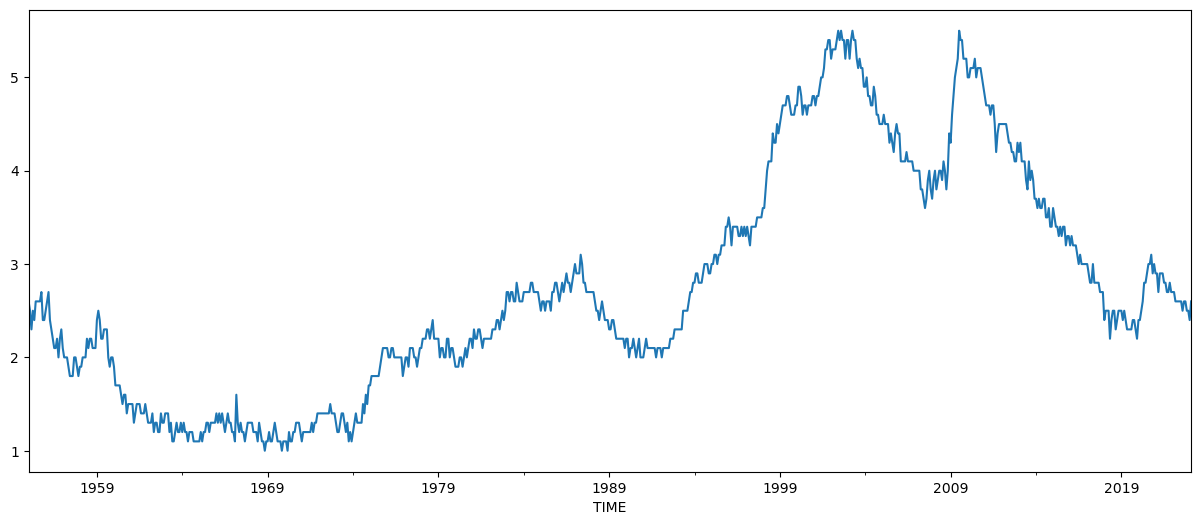

In [7]:
df_unemployment_monthly['Value'].plot(figsize=(15, 6))
plt.show()

#### 2.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

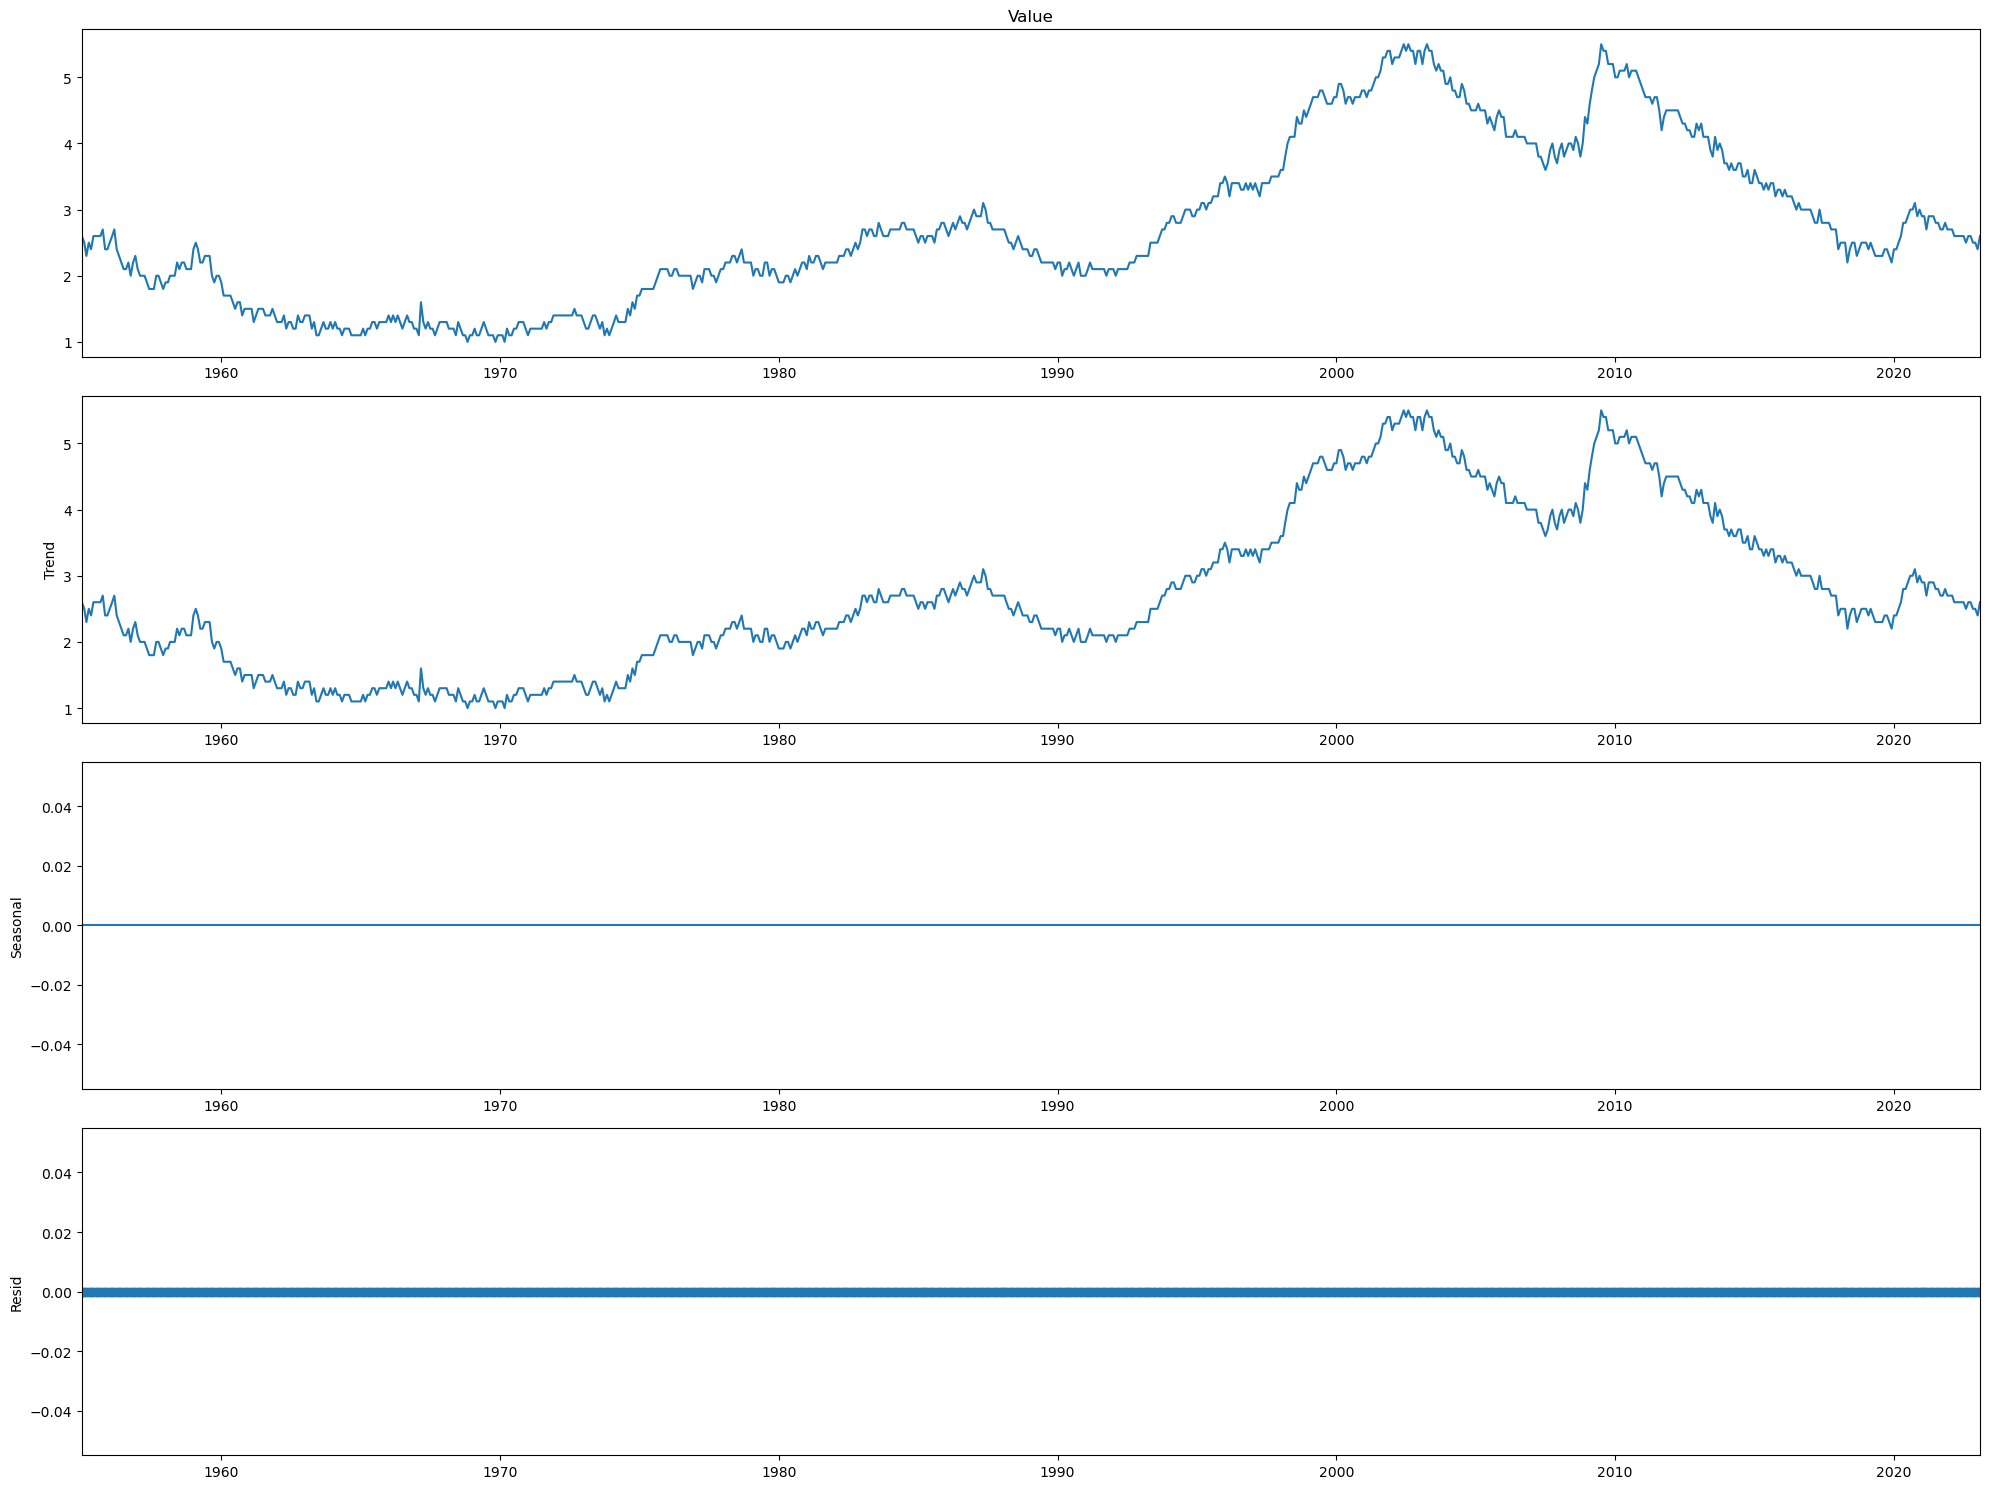

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_monthly['Value'], model='additive',period=1)
fig = decomposition.plot()
plt.show()

#### 2.1.2. Checking Stationarity

In [9]:
adfuller_result = adfuller(df_unemployment_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('------Non-stationary time series. Checking first difference------------')
    df_unemployment_monthly_transformed = df_unemployment_monthly['Value'].diff().dropna()
    adfuller_result = adfuller(df_unemployment_monthly_transformed.values, autolag='AIC')
    print('ADF statistics at first difference: ', adfuller_result[0])
    print('p-value: ', adfuller_result[1])
else:
    print('Stationary time series')

ADF statistics:  -1.3619917354566111
p-value:  0.6003561164037798
------Non-stationary time series. Checking first difference------------
ADF statistics at first difference:  -6.756109939387772
p-value:  2.8690607557431384e-09


### 2.2. Modelling 

In [10]:
train_limit=df_unemployment_monthly.shape[0]-12

Y_train=df_unemployment_monthly.iloc[0:train_limit,5]
Y_validation=df_unemployment_monthly.iloc[train_limit:,5]
Y_full=df_unemployment_monthly.iloc[:,5]

#### 2.2.1. Determining optimum p,d,q values

In [11]:
%%time

def evaluate_sarimax_model(Y_train, Y_validation, order):
    mod = sm.tsa.statespace.SARIMAX(Y_train,
                                    order=order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_arima_model(Y_train, Y_validation, order):
    mod = ARIMA(Y_train,
                order=order)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_models(dataset, validation_dataset,p_values,d_values,q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, validation_dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%s' % (order,rmse))

    print('Best ARIMA%s RMSE= %s' % (best_cfg, best_score))
    return best_cfg
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg=evaluate_models(Y_train, Y_validation, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.19478692267560133
ARIMA(0, 0, 2) RMSE=0.18587427501313572
ARIMA(0, 1, 0) RMSE=0.15545631755148037
ARIMA(0, 2, 1) RMSE=0.1320260472006679
ARIMA(0, 2, 2) RMSE=0.11557666788584602
ARIMA(1, 2, 1) RMSE=0.10969573061831112
ARIMA(2, 2, 0) RMSE=0.06348326598483078
ARIMA(8, 2, 0) RMSE=0.061306340577870176
Best ARIMA(8, 2, 0) RMSE= 0.061306340577870176
Wall time: 2min 26s


In [12]:
# stepwise_fit = auto_arima(Y_train, start_p=0,max_p=10, start_d=2, max_d=3, start_q =0, max_q=3,trace=True,suppress_warnings=True)
# stepwise_fit.summary()

#### 2.2.2. Fitting Model

In [13]:
mod = ARIMA(Y_train,order=best_cfg)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1205      0.032    -35.054      0.000      -1.183      -1.058
ar.L2         -1.1515      0.048    -24.081      0.000      -1.245      -1.058
ar.L3         -1.0038      0.058    -17.450      0.000      -1.116      -0.891
ar.L4         -0.8067      0.064    -12.650      0.000      -0.932      -0.682
ar.L5         -0.6416      0.063    -10.170      0.000      -0.765      -0.518
ar.L6         -0.4672      0.063     -7.465      0.000      -0.590      -0.345
ar.L7         -0.2737      0.048     -5.748      0.000      -0.367      -0.180
ar.L8         -0.1264      0.035     -3.620      0.000      -0.195      -0.058
sigma2         0.0112      0.000     24.035      0.000       0.010       0.012


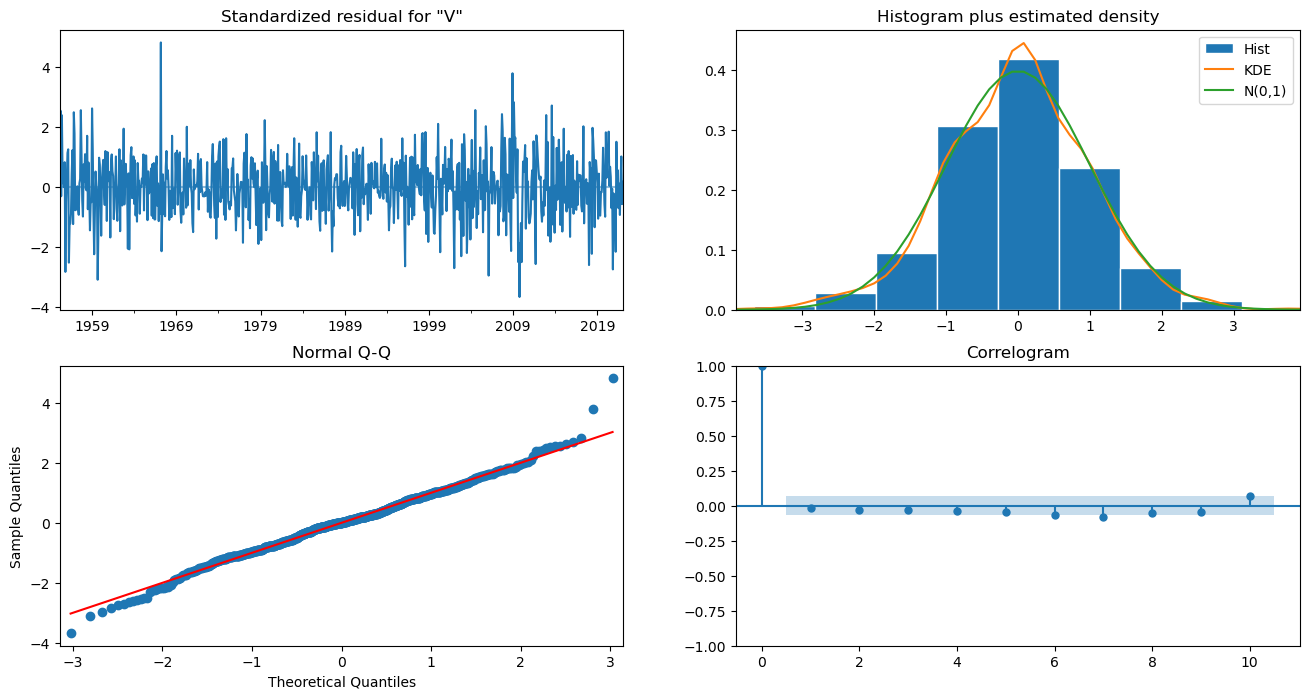

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 2.2.3. Model Results

In [15]:
predictions={}
for date in Y_validation.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [16]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_validation.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(mse)))

The Root Mean Squared Error of our forecasts is 0.061306340577870176


#### 2.2.4. Training on Full Data and Predicting

In [17]:
mod_full_data = ARIMA(Y_full,order=best_cfg)
results_full_data = mod_full_data.fit()
print(results_full_data.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1240      0.032    -35.482      0.000      -1.186      -1.062
ar.L2         -1.1555      0.047    -24.348      0.000      -1.249      -1.062
ar.L3         -1.0082      0.057    -17.685      0.000      -1.120      -0.897
ar.L4         -0.8127      0.063    -12.848      0.000      -0.937      -0.689
ar.L5         -0.6426      0.063    -10.250      0.000      -0.765      -0.520
ar.L6         -0.4692      0.062     -7.547      0.000      -0.591      -0.347
ar.L7         -0.2748      0.047     -5.807      0.000      -0.368      -0.182
ar.L8         -0.1245      0.035     -3.592      0.000      -0.192      -0.057
sigma2         0.0112      0.000     24.238      0.000       0.010       0.012


In [18]:
preds_df = (results_full_data
            .get_prediction(start='2023-01-01', end='2023-05-01')
            .summary_frame(alpha=0.05)
)

preds_df

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,2.505693,0.105650,2.298623,2.712763
2023-02-01,2.397351,0.105650,2.190281,2.604421
2023-03-01,2.556680,0.105650,2.349610,2.763750
2023-04-01,2.528434,0.140451,2.253155,2.803713
2023-05-01,2.528436,0.167270,2.200592,2.856280
